# Comparison of DQL Networks
<strong>Michael Ruggiero<br>
Tuesday, August 6th, 2019<br>
michael@mcruggiero.com</strong>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Basic-Imports" data-toc-modified-id="Basic-Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic Imports</a></span></li><li><span><a href="#Framework" data-toc-modified-id="Framework-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Framework</a></span><ul class="toc-item"><li><span><a href="#Cuda-Support" data-toc-modified-id="Cuda-Support-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Cuda Support</a></span></li><li><span><a href="#Environment" data-toc-modified-id="Environment-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Environment</a></span></li><li><span><a href="#Learning-and-Network-Parameters" data-toc-modified-id="Learning-and-Network-Parameters-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Learning and Network Parameters</a></span></li></ul></li><li><span><a href="#Functions" data-toc-modified-id="Functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Display-Functions" data-toc-modified-id="Display-Functions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Display Functions</a></span></li><li><span><a href="#Network-Functions" data-toc-modified-id="Network-Functions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Network Functions</a></span></li><li><span><a href="#Loop-Function" data-toc-modified-id="Loop-Function-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Loop Function</a></span></li></ul></li></ul></div>

# Complete Code

## Introduction

The goal of this project will be to provide a code heavy presentation of a neural network to solve the "Cartpole problem." Also, some visulizations will be explored.

## Basic Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from time import time
import gym
import math

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Framework

### Cuda Support

In [2]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Tensor = torch.Tensor

### Environment

In [3]:
### Number of runs
num_episodes = 100
score_to_solve = 200
###

env = gym.make('CartPole-v1')
inputs = env.observation_space.shape[0]
outputs = env.action_space.n

print("Input Space:\t{}\nOutput Space:\t{}".format(inputs, outputs))

Input Space:	4
Output Space:	2


### Learning and Network Parameters

In [4]:
learning_rate = 0.02
gamma = 0.99

egreedy = 0.9
egreedy_final = 0.001
egreedy_decay = num_episodes * 5
report_interval = 10

hidden_layer = 64

## Functions

### Display Functions

In [5]:
def display_frames(episode):
    plt.figure(figsize=(shadow_run[episode]["shots"][0].shape[1] / 72.0,
                        shadow_run[episode]["shots"][0].shape[0] / 72.0))
    
    for i in shadow_run[episode]["shots"]:
        plt.imshow(i, alpha = .25)
    plt.axis('off');
    plt.title("Number of steps: {}".format(shadow_run[episode]["steps"]),
              fontdict={'fontsize': 25, 'fontweight': 'medium'});
    
    plt.show()
    
def plot_information(steps_total, shadow_run):
    e_list = []
    for i in shadow_run:
        for j in shadow_run[i]["epsilon"]:
            e_list.append(j)
    
    #s = list(range(sum(steps_total)))
    
    fig, ax = plt.subplots(figsize=(12,10), nrows=2, ncols=1)
    fig.subplots_adjust(hspace=.25)

    ax[0].set(title="Rewards",
              xlabel='Session', 
              ylabel='Steps')
    ax[0].bar(torch.arange(len(steps_total)), 
            steps_total, 
            alpha=0.6, 
            color='green',
            width= 1)
    
    ax[1].set(title="Epsilon",
          xlabel='Steps', 
          ylabel='Session')
    ax[1].plot(e_list)
    plt.show()
    
def report(report_interval, episode, start_time, steps_total, epsilon, frames_total, solved):
    if episode % report_interval == 0 and episode != 0:
        print("""\t\t\t *** Episode {} at Total Seconds {:2f}***
                 Average Reward for last {} steps: {:2f}
                 Average Reward for all steps: {:2f}
                 Epsilon: {}, Frames Total :{}
                 Solved {} Times
              """.format(episode,
                   (time() - start_time),
                   str(report_interval),
                   sum(steps_total[-report_interval:])/report_interval,
                   sum(steps_total)/len(steps_total),
                   epsilon,
                   frames_total,
                   solved))

### Network Functions

In [6]:
# Torch Template
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

#Code Borrowed heavily from Atamai Udemy Course
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(inputs,hidden_layer)
        self.linear2 = nn.Linear(hidden_layer,hidden_layer)
        self.linear3 = nn.Linear(hidden_layer,outputs)
        
        self.activation = nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        
        reward = Tensor([reward]).to(device)
        
        if done:
            target_value = reward
        else:
            new_state_values = self.nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma * max_new_state_values
        
        predicted_value = self.nn(state)[action]
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### Loop Function

In [7]:
qnet_agent = QNet_Agent()
start_time = time()
solved, frames_total = 0, 0
steps_total = []
shadow_run = {}

for episode in range(num_episodes):
    # Episode Initializations
    state = env.reset()
    shadow_run[episode] = {}
    actions, states, shots, epi_list = [], [], [], []
    step = 0

    while True:
        step += 1
        frames_total += 1

        epsilon = calculate_epsilon(frames_total)

        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)

        new_state, reward, done, info = env.step(action)
        rendered = env.render(mode = 'rgb_array')

        # Agent Optimize
        qnet_agent.optimize(state, action, new_state, reward, done)

        # Store states for step
        actions.append(action)
        states.append(new_state)
        shots.append(rendered)
        epi_list.append(epsilon)

        if done:
            steps_total.append(step)
            shadow_run[episode]["actions"] = actions
            shadow_run[episode]["states"] = states
            shadow_run[episode]["shots"] = shots
            shadow_run[episode]["steps"] = step
            shadow_run[episode]["epsilon"] = epi_list

            if step >= score_to_solve: solved += 1

            report(report_interval, episode, start_time, steps_total, epsilon, frames_total, solved)

            break

        state = new_state

env.close()
env.env.close()

plot_information(steps_total,shadow_run)
display_frames(num_episodes-1)

AssertionError: 29 (<class 'int'>) invalid

In [21]:
shadow_run[85]['states']

[array([ 0.01003843,  0.20243672, -0.03018826, -0.30069966]),
 array([ 0.01408717,  0.00775776, -0.03620225, -0.01768828]),
 array([ 0.01424232, -0.18682681, -0.03655602,  0.2633562 ]),
 array([ 0.01050579,  0.00879735, -0.03128889, -0.04062907]),
 array([ 0.01068173, -0.18586228, -0.03210147,  0.24202002]),
 array([ 0.00696449,  0.00970316, -0.02726107, -0.06061322]),
 array([ 0.00715855, -0.18501753, -0.02847334,  0.22334553]),
 array([ 0.0034582 ,  0.01049957, -0.02400643, -0.07818128]),
 array([ 0.00366819, -0.18427016, -0.02557005,  0.20683192]),
 array([-1.72102414e-05,  1.12079296e-02, -2.14334155e-02, -9.38061343e-02]),
 array([ 0.00020695, -0.18360037, -0.02330954,  0.19203825]),
 array([-0.00346506,  0.01184715, -0.01946877, -0.10790577]),
 array([-0.00322812, -0.18299048, -0.02162689,  0.17857183]),
 array([-0.00688793,  0.01243418, -0.01805545, -0.12085441]),
 array([-0.00663924, -0.1824245 , -0.02047254,  0.16607795]),
 array([-0.01028773,  0.01298443, -0.01715098, -0.1329

In [15]:
shadow_run[112]['shots']

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [16]:
def display_frames(episode):
    plt.figure(figsize=(shadow_run[episode]["shots"][0].shape[1] / 72.0,
                        shadow_run[episode]["shots"][0].shape[0] / 72.0))
    
    for i in shadow_run[episode]["shots"]:
        plt.imshow(i, alpha = .25)
    plt.axis('off');
    plt.title("Number of steps: {}".format(shadow_run[episode]["steps"]),
              fontdict={'fontsize': 25, 'fontweight': 'medium'});

In [17]:
shadow_run[0]["shots"]

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [46]:
a

NameError: name 'a' is not defined

In [142]:
display_frames(calculate_epsilon(23000)

0.01

In [18]:
def display_frames(episode):
    plt.figure(figsize=(shadow_run[episode]["shots"][0].shape[1] / 72.0,
                        shadow_run[episode]["shots"][0].shape[0] / 72.0))
    
    for i in shadow_run[episode]["shots"]:
        plt.imshow(i, alpha = .25)
    plt.axis('off');
    plt.title("Number of steps: {}".format(shadow_run[episode]["steps"]),
              fontdict={'fontsize': 50, 'fontweight': 'medium'});

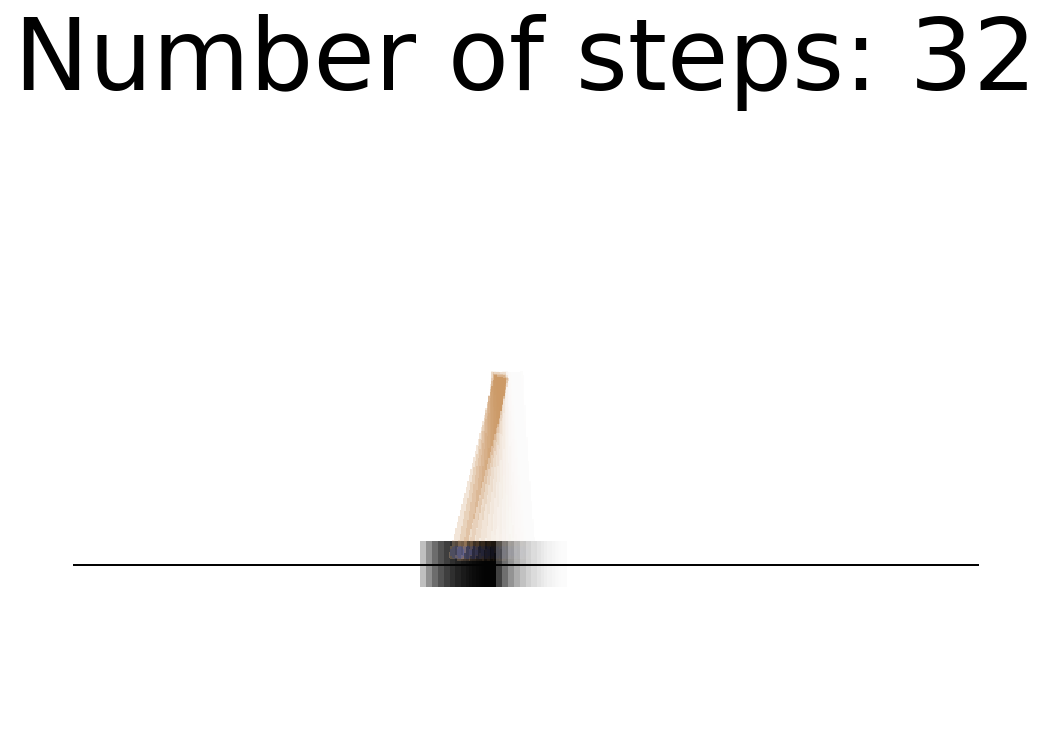

In [19]:
display_frames(5)


KeyError: 'steps'

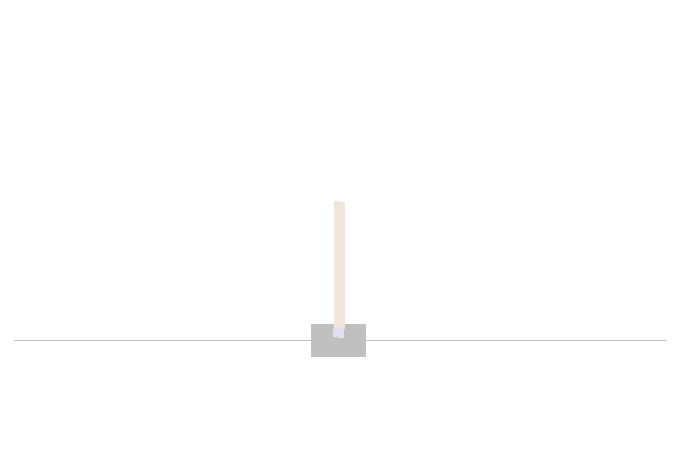

In [20]:
for i in shadow_run[0]["shots"]:
    plt.imshow(i, alpha = .25)
    plt.axis('off');
    plt.title("Number of steps: {}".format(shadow_run[episode]["steps"]),
              fontdict={'fontsize': 50, 'fontweight': 'medium'});

TypeError: Invalid shape (11, 400, 600, 3) for image data

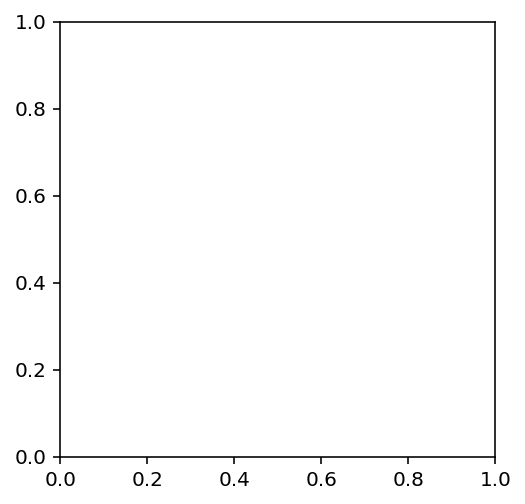

In [21]:
plt.imshow(shadow_run[0]["shots"], alpha = .25)

In [67]:
plt.imshow()

SyntaxError: unexpected EOF while parsing (<ipython-input-67-9c6170dfe46f>, line 1)

In [70]:
shadow_run[5]["shots"]

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 